# 1. INTRODUCTION
Predicting the popularity of news articles hasn't been a very successful field. A major reason behind the same is the availability of only one prominent UCI dataset with a significant amount of features, many of which aren't required. Not only that, the calculation of these features for web crawled data remains ambiguous. In this project, I shall attempt to extract relevant features(not just those which have high correlation with the target variable, but those which can be calculated for web crawled data as well). I shall begin by building a web crawler to go over Mashable's website and extract news articles. Then, I shall shift my focus to the UCI dataset, carry out some feature engineering and train the model using binary classification and validating the accuracy with cross validation. After doing so, I will extract relevant features out of crawled data and make predictions. Finally, I will present an idea: A different way of solving this issue which I couldn't explore since I had to complete this project under a time constraint but would ****explore in the future.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#For correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
        
#For web crawling       
!pip install newspaper3k
import requests
from bs4 import BeautifulSoup
from newspaper import Article  
import csv 
import newspaper

#For model training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

#For web data feature extraction
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
from textblob import TextBlob


# Any results you write to the current directory are saved as output.

/kaggle/input/online-news-popularity/OnlineNewsPopularity.csv
/kaggle/input/online-news-popularity/OnlineNewsPopularity.names
     |████████████████████████████████| 211 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 192 kB 61.7 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 7.4 MB 80.6 MB/s eta 0:00:01
  Created wheel for feedparser: filename=feedparser-5.2.1-py3-none-any.whl size=44939 sha256=90b31d0e81f6218e2bf38b784eeae75953c30460f13fcbdd7ce52abc3958a698
  Stored in directory: /root/.cache/pip/wheels/2f/70/50/16138238f6447854a1300f7d457766789dc7122cfaf46bcef2
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13538 sha256=ca1d6d9abcab5d6d208cba361f39bd27be80019938717ecb0408f0de98213ae0
  Stored in directory: /root/.cache/pip/wheels/1a/ca/c1/1e27eacc3fd0cca25b5383253141ba07694e926a10c3bdc549
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-no

Using TensorFlow backend.


# 2. WEB CRAWLING
I will be building a web crawler that browses the Mashable website and retrieves the latest articles. In order to fully explore the power of the Newspaper 3k library, I will be extracting the title, text, summary and keywords. Not all of these are important for my model's features, but they do indicate the power of the Newspaper 3k library and present avenues for novel datset synthesis.

In [2]:
#Importing Mashable newspaper
mas_paper = newspaper.build('http://mashable.com')

In [3]:
print(mas_paper.size()) #number of articles

1131


In [4]:
tdf=[]
for article in mas_paper.articles:
        article.download() 
        try:
            article.parse()
        except:
            continue
        article.nlp() 
        data={}
        data['Title']=article.title
        data['Text']=article.text
        data['Summary']=article.summary
        data['Keywords']=article.keywords
        tdf.append(data)

In [5]:
tdf=pd.DataFrame(tdf)
tdf.head()

,Title,Text,Summary,Keywords
0,"Best streaming services: We compare Disney+, P...",All products featured here are independently s...,Top picks for best streaming services: PlaySta...,"[sling, plan, offers, vue, compare, playstatio..."
1,Best free dating sites and apps for singles on...,If you're not sure about which dating site you...,"But for some dating apps and sites, the free v...","[good, match, tinder, youre, sites, free, youl..."
2,Which DNA test kit should you get?,DNA test kits like AncestryDNA and 23andMe hav...,We've looked at seven of the most popular DNA ...,"[tests, price, results, family, testing, dna, ..."
3,Show mom (and Mother Earth) some love with the...,All products featured here are independently s...,The first person who comes to mind when we hea...,"[earth, wont, report, gifts, ecofriendly, moth..."
4,Best Mother's Day gifts for moms who aren't in...,All products featured here are independently s...,"If your parents are hip and tech savvy, shoppi...","[arent, things, gifts, way, tech, mothers, kno..."


# 3. DATA PREPROCESSING AND FEATURE ENGINEERING
Fortunately, this dataset is rather clean and simple. However, I have addressed an issue I observed regarding missing values, Then, since we have to anticipate likelihood of virality, I conveted the number of shares to probability. Then, I analyzed the correlation matrix to decide which features I should go for.

In [6]:
df=pd.read_csv('../input/online-news-popularity/OnlineNewsPopularity.csv', skipinitialspace=True)
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


Missing values are very troubling in this data set because they are coded as 0. So you have to judge if the 0 are missing or real data. By checking the distributions, I found around 3000 observations with missing values in 9 different variables. 

In [7]:
columns=[df.columns[11],df.columns[20],df.columns[44],df.columns[45],df.columns[46],df.columns[48],df.columns[49],df.columns[50],df.columns[53]]
df=df.replace(0, pd.np.nan).dropna(axis=0, how='any', subset=columns).fillna(0)
df.index = pd.RangeIndex(start=0, stop=36274, step=1)
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/08/artist-drone-pi...,730.0,12.0,288.0,0.589474,1.0,0.726190,5.0,2.0,0.0,...,0.166667,1.00,-0.366667,-0.80,-0.100000,0.000000,0.000000,0.500000,0.000000,755
1,http://mashable.com/2013/01/08/japanese-cat-bo...,730.0,10.0,414.0,0.606796,1.0,0.777344,8.0,0.0,1.0,...,0.100000,0.50,-0.176128,-0.70,-0.050000,0.300000,0.200000,0.200000,0.200000,468
2,http://mashable.com/2013/01/08/lego-iphone-case/,730.0,11.0,134.0,0.702290,1.0,0.785714,4.0,2.0,9.0,...,0.136364,0.80,-0.150000,-0.15,-0.150000,0.000000,0.000000,0.500000,0.000000,4600
3,http://mashable.com/2013/01/08/nfl-arian-foste...,730.0,11.0,281.0,0.610714,1.0,0.766467,5.0,4.0,1.0,...,0.136364,0.50,-0.278472,-0.50,-0.050000,0.000000,0.000000,0.500000,0.000000,1300
4,http://mashable.com/2013/01/08/personal-for-ed...,730.0,12.0,499.0,0.513026,1.0,0.662252,14.0,1.0,1.0,...,0.100000,0.50,-0.235000,-0.50,-0.100000,0.300000,0.000000,0.200000,0.000000,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36269,http://mashable.com/2014/12/27/protests-contin...,8.0,11.0,223.0,0.653153,1.0,0.825758,5.0,3.0,1.0,...,0.214286,0.80,-0.250000,-0.25,-0.250000,0.000000,0.000000,0.500000,0.000000,1200
36270,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.100000,0.75,-0.260000,-0.50,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
36271,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.136364,0.70,-0.211111,-0.40,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
36272,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.136364,0.50,-0.356439,-0.80,-0.166667,0.454545,0.136364,0.045455,0.136364,1900


In [8]:
#Converting number of shares to probability to virality
df.shares.median()

1400.0

In [9]:
i=0
while i<36274:
    if df.shares[i]>=1400:
        df.shares[i]=1
    else:
        df.shares[i]=0
    i=i+1
df.shares

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0        0
1        0
2        1
3        0
4        0
        ..
36269    0
36270    1
36271    1
36272    1
36273    0
Name: shares, Length: 36274, dtype: int64

In [10]:
#Dropping non predictable columns
df=df.drop(columns=['url','timedelta'])
df.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,288.0,0.589474,1.0,0.726190,5.0,2.0,0.0,0.0,4.381944,...,0.166667,1.0,-0.366667,-0.80,-0.10,0.0,0.0,0.5,0.0,0
1,10.0,414.0,0.606796,1.0,0.777344,8.0,0.0,1.0,0.0,4.980676,...,0.100000,0.5,-0.176128,-0.70,-0.05,0.3,0.2,0.2,0.2,0
2,11.0,134.0,0.702290,1.0,0.785714,4.0,2.0,9.0,0.0,4.477612,...,0.136364,0.8,-0.150000,-0.15,-0.15,0.0,0.0,0.5,0.0,1
3,11.0,281.0,0.610714,1.0,0.766467,5.0,4.0,1.0,0.0,4.608541,...,0.136364,0.5,-0.278472,-0.50,-0.05,0.0,0.0,0.5,0.0,0
4,12.0,499.0,0.513026,1.0,0.662252,14.0,1.0,1.0,0.0,5.084168,...,0.100000,0.5,-0.235000,-0.50,-0.10,0.3,0.0,0.2,0.0,0


58 features certainly sounds like a lot, and I'm sure can be reduced. Also, the web crawled data is raw and not all of these features can be extracted. Hence, I'm going to find the most important features(which can be extracted) and use those.

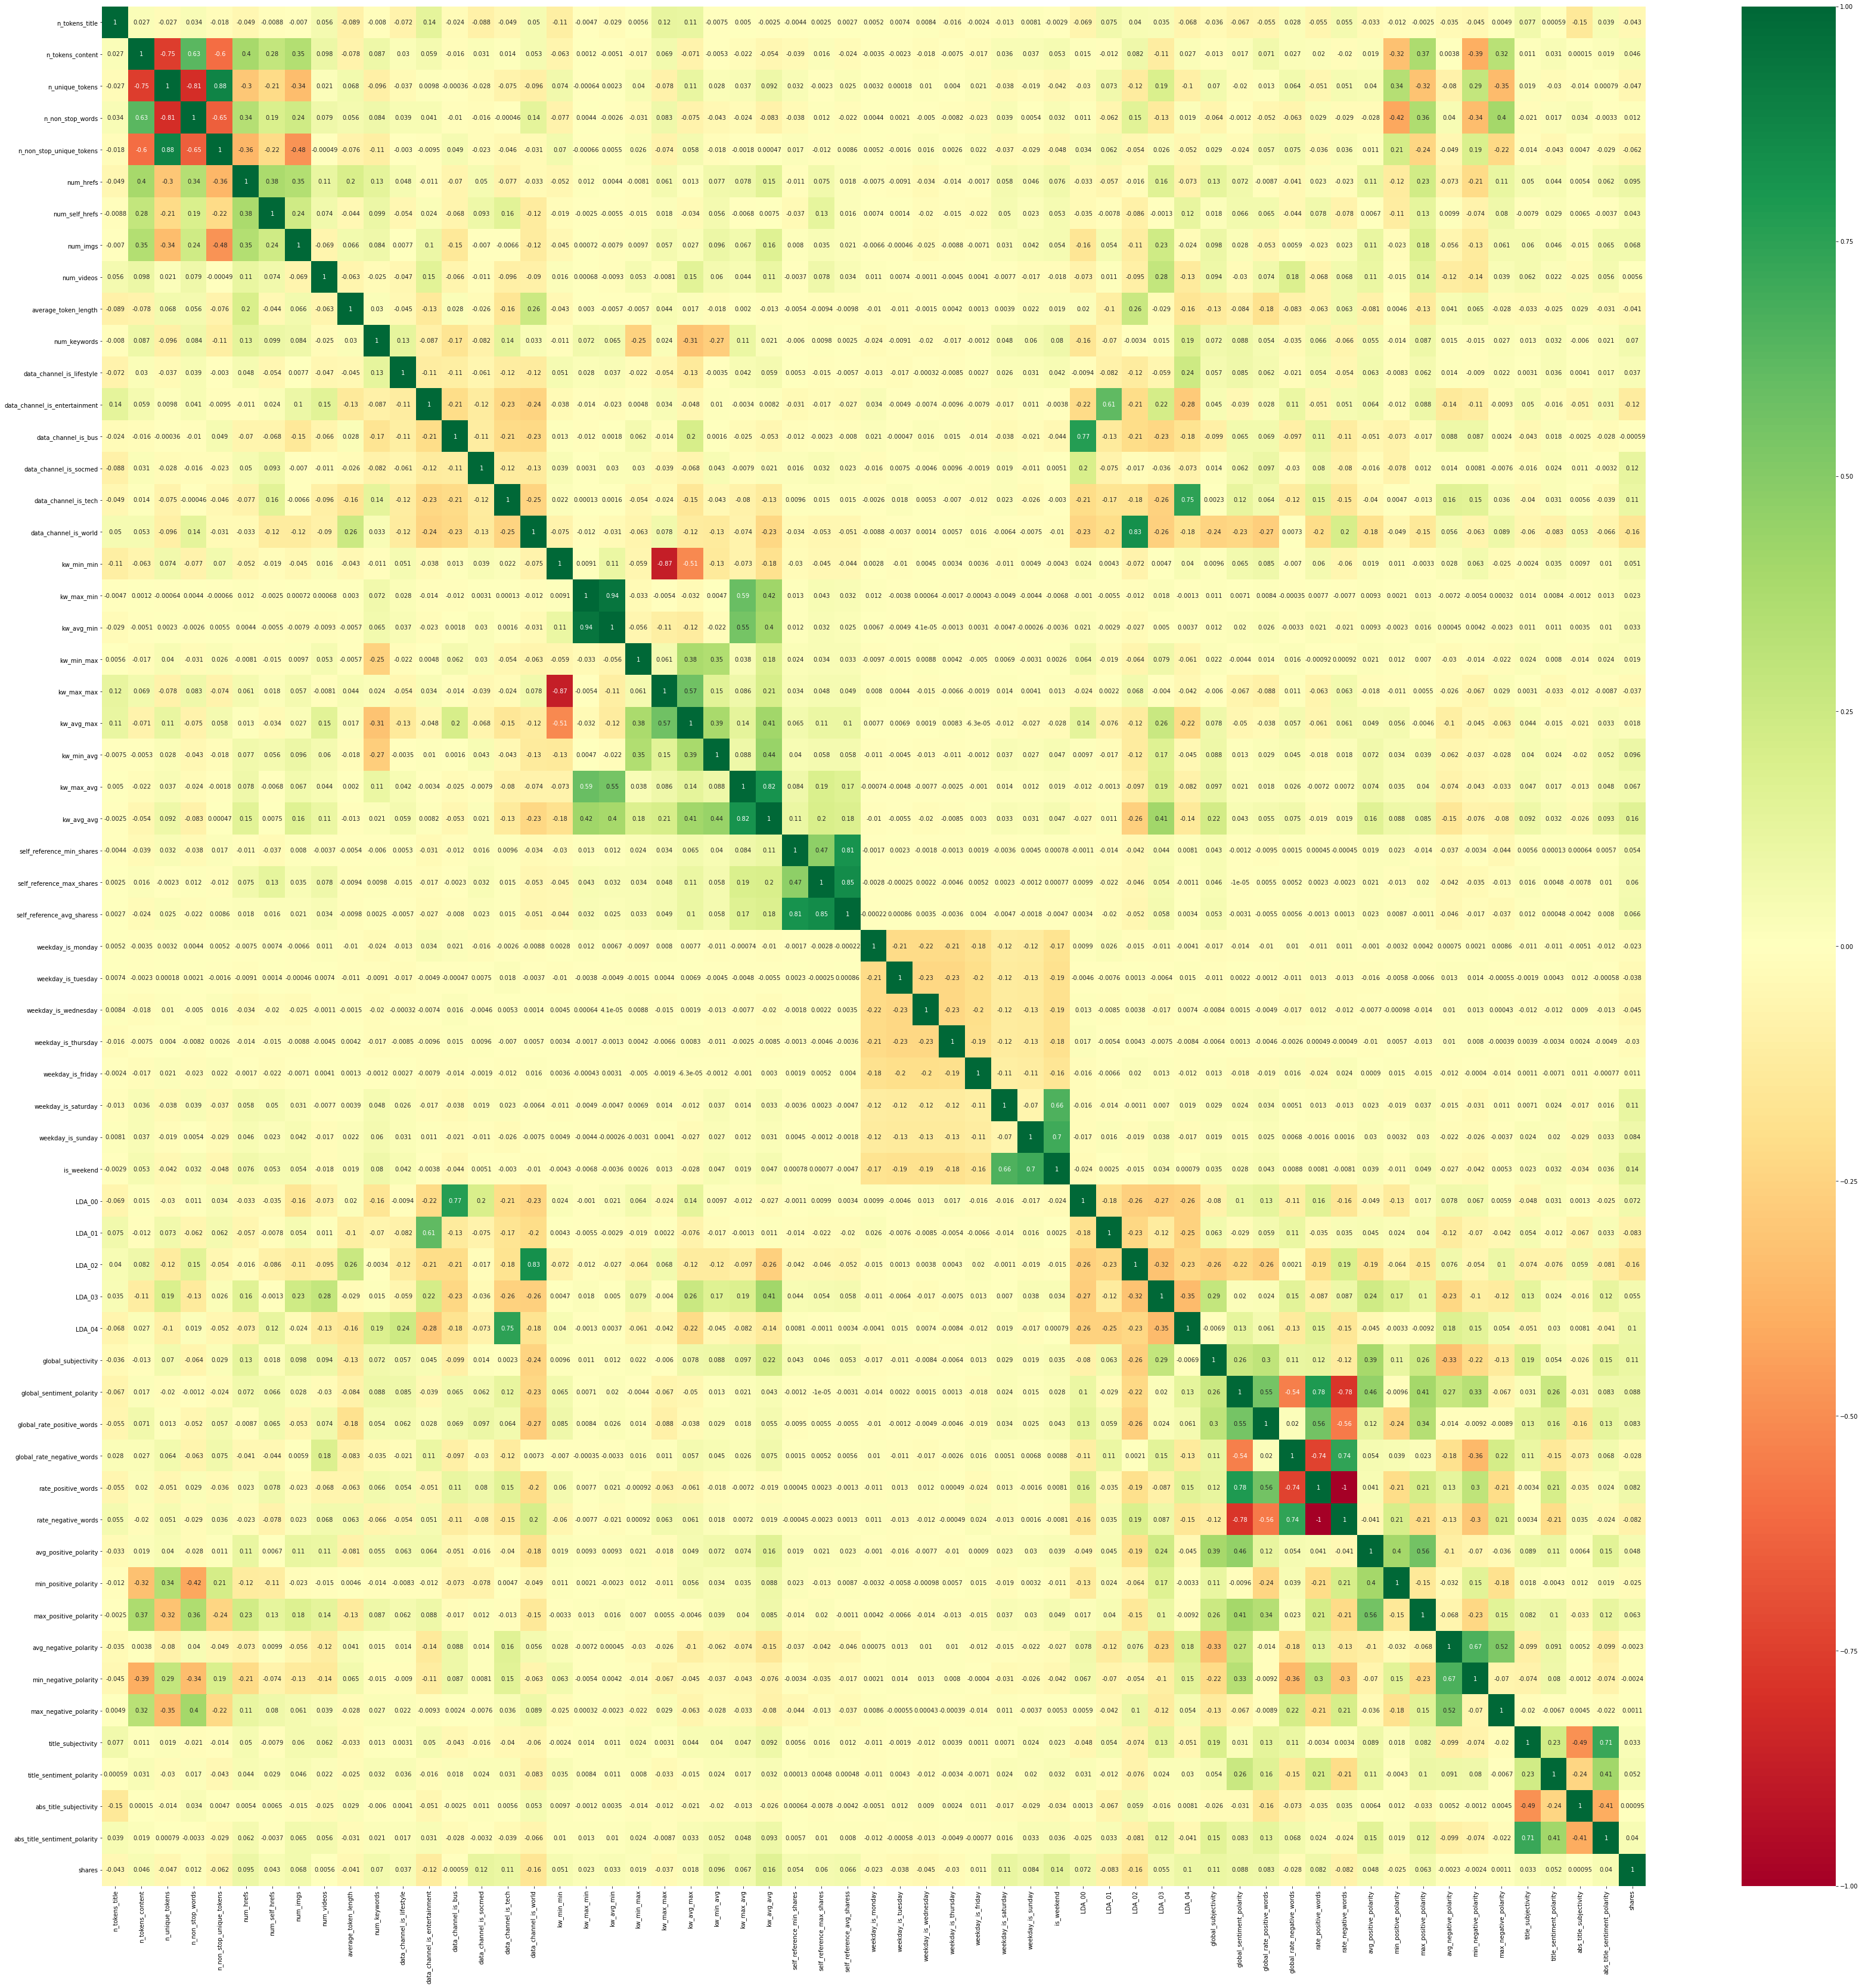

In [11]:
X = df.iloc[:,0:57]  #independent columns
y = df.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(58,58))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")


This exposes a major flaw of the data: None of the features are good enough. The target variable, shares(probability of virality), doesn't have a significant correlation with any feature.

In [12]:
#Correlation with output variable
cor_target = abs(corrmat["shares"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
relevant_features

n_non_stop_unique_tokens         0.062205
num_hrefs                        0.094612
num_imgs                         0.067880
num_keywords                     0.070096
data_channel_is_entertainment    0.118117
data_channel_is_socmed           0.118969
data_channel_is_tech             0.106758
data_channel_is_world            0.157944
kw_min_min                       0.050697
kw_min_avg                       0.095715
kw_max_avg                       0.067020
kw_avg_avg                       0.156925
self_reference_min_shares        0.053814
self_reference_max_shares        0.060483
self_reference_avg_sharess       0.065663
weekday_is_saturday              0.111038
weekday_is_sunday                0.084438
is_weekend                       0.142774
LDA_00                           0.072337
LDA_01                           0.083047
LDA_02                           0.163938
LDA_03                           0.055100
LDA_04                           0.100115
global_subjectivity              0

# Model training

I have chosen some of the columns above, ones which weren't too closely related with one another and could be calculated for web data. I have scaled the data using StandardScaler and built my logistic regression model(as a neural network) using keras.

In [13]:
trdf=df[['n_non_stop_unique_tokens','num_hrefs','num_imgs','num_videos','average_token_length','num_keywords','data_channel_is_world','data_channel_is_entertainment','data_channel_is_socmed','data_channel_is_tech','avg_negative_polarity','global_subjectivity','global_sentiment_polarity','global_rate_positive_words','max_positive_polarity','title_sentiment_polarity' ]].copy()
y=df.shares

In [14]:
#Splitting
X_train, X_test, y_train, y_test = train_test_split(trdf, y, test_size=0.2, random_state=42)
np.shape(X_train)
print(y_train)

14471    0
23719    1
5843     0
31429    1
25361    0
        ..
16850    1
6265     1
11284    1
860      1
15795    0
Name: shares, Length: 29019, dtype: int64


In [15]:
# Standardize data (0 mean, 1 stdev)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler1 = StandardScaler().fit(X_test)
X_test = scaler1.transform(X_test)

In [ ]:
#K-fold validation
def create_baseline():
# create model
 model = Sequential()
 model.add(Dense(9, input_dim=16, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
# Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_test, y_test, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [57]:
#Create model
model = Sequential()
model.add(Dense(9, input_dim=16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#Fit model
model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=0)

# Converting web data to features available
This is a computationally expensive process. Hence, I decided to review just a few random articles. 

In [25]:
def rate_nonstop(words):
    words=word_tokenize(words)
    filtered_sentence = [w for w in words if not w in stopwords]
    rate_nonstop=len(filtered_sentence)/len(words)
    no_order = list(set(filtered_sentence))
    rate_unique_nonstop=len(no_order)/len(words)
    return rate_unique_nonstop

In [26]:
def avg_token(words):
    words=word_tokenize(words)
    length=[]
    for i in words:
        length.append(len(i))
    return np.average(length)

In [27]:
pos_words=[]
neg_words=[]
def polar(words):
    all_tokens=word_tokenize(words)
    for i in all_tokens:
        analysis=TextBlob(i)
        polarity=analysis.sentiment.polarity
        if polarity>0:
            pos_words.append(i)
        if polarity<0:
            neg_words.append(i)
    return pos_words,neg_words

In [28]:
def rates(words):
    words=polar(words)
    pos=words[0]
    neg=words[1]
    all_words=words
    global_rate_positive_words=(len(pos)/len(all_words))/100
    pol_pos=[]
    pol_neg=[]
    for i in pos:
        analysis=TextBlob(i)
        pol_pos.append(analysis.sentiment.polarity)
        avg_positive_polarity=analysis.sentiment.polarity
    for j in neg:
        analysis2=TextBlob(j)
        pol_neg.append(analysis2.sentiment.polarity)
        avg_negative_polarity=analysis2.sentiment.polarity
    max_positive_polarity=max(pol_pos)
    avg_negative_polarity=np.average(pol_neg)
    return global_rate_positive_words,max_positive_polarity,avg_negative_polarity

In [49]:
findf=[]
for article in mas_paper .articles[310:320]:
    article.download() 
    article.parse()
    pinfo={}
    analysis=TextBlob(article.text)
    polarity=analysis.sentiment.polarity
    title_analysis=TextBlob(article.title)
    pinfo['n_non_stop_unique_tokens']=rate_nonstop(article.text)
    pinfo['num_hrefs']=article.html.count('http://mashable.com')
    pinfo['num_imgs']=len(article.images)
    pinfo['num_videos']=len(article.movies)
    pinfo['average_token_length']=avg_token(article.text)
    pinfo['num_keywords']=len(article.keywords)
    if "world" in article.text.lower():
        pinfo['data_channel_is_world']=1
    else:
        pinfo['data_channel_is_world']=0
    if "entertainment" in article.text.lower():
        pinfo['data_channel_is_entertainment']=1
    else:
        pinfo['data_channel_is_entertainment']=0
    if "social-media" in article.text.lower():
        pinfo['data_channel_is_socmed']=1
    else:
        pinfo['data_channel_is_socmed']=0
    if "tech" in article.text.lower():
         pinfo['data_channel_is_tech']=1
    else:
        pinfo['data_channel_is_tech']=0
    pinfo['avg_negative_polarity']=rates(article.text)[2]
    pinfo['global_subjectivity']=analysis.sentiment.subjectivity
    pinfo['global_sentiment_polarity']=analysis.sentiment.polarity
    pinfo['global_rate_positive_words']=rates(article.text)[0]
    pinfo['max_positive_polarity']=rates(article.text)[1]
    pinfo['title_sentiment_polarity']=title_analysis.sentiment.polarity
    findf.append(pinfo)

In [50]:
findf=pd.DataFrame(findf)
findf

,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_world,data_channel_is_entertainment,data_channel_is_socmed,data_channel_is_tech,avg_negative_polarity,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,max_positive_polarity,title_sentiment_polarity
0,0.391499,0,12,9,4.275168,16,0,0,0,1,-0.317310,0.450138,0.127021,27.075,1.0,-0.300000
1,0.575221,0,12,0,3.929204,13,1,0,0,1,-0.316737,0.366667,0.266667,27.300,1.0,0.000000
2,0.340762,0,12,0,4.583753,13,1,0,0,0,-0.317018,0.391989,0.143984,27.970,1.0,0.266667
3,0.350376,5,17,0,4.151880,13,0,0,0,0,-0.317072,0.504239,0.168850,28.590,1.0,0.200000
4,0.395466,1,13,0,4.007557,13,1,0,0,0,-0.316421,0.532146,0.047905,28.905,1.0,0.000000
5,0.405556,0,19,1,3.803704,15,0,0,0,0,-0.314998,0.493703,0.032283,29.210,1.0,-0.187500
6,0.388158,0,12,0,4.256579,14,0,0,0,1,-0.310708,0.303038,0.060104,29.440,1.0,0.300000
7,0.472441,0,12,0,3.984252,14,0,0,0,1,-0.310049,0.391905,0.339524,29.540,1.0,0.300000
8,0.511628,0,12,0,4.040698,14,0,0,0,0,-0.309997,0.477576,0.150189,29.640,1.0,0.000000
9,0.376321,0,12,0,4.238901,11,0,0,0,1,-0.309424,0.466111,0.084197,29.930,1.0,0.000000


# Predicting probability of virality
In order to ensure that input data is similar to data the model was trained on, I will apply StandardScaler once again.

In [58]:
# Standardize data (0 mean, 1 stdev) and predict
scaler = StandardScaler().fit(findf)
findf = scaler.transform(findf)
predictions= model.predict(findf)

In [59]:
print(predictions)

[[0.5579683 ]
 [0.41134048]
 [0.19376273]
 [0.65883154]
 [0.35364   ]
 [0.6172778 ]
 [0.4800378 ]
 [0.3735532 ]
 [0.45321533]
 [0.4685592 ]]


# Conclusion
There's no way to predict the accuracy of my probability predictions. I did my best with the limited features that I could extract out of web crawled data. Hence, there is a strong need for alternative news popularity datasets where feature extraction from raw data is defined and convenient. Nonetheless, the model did give a K-fold cross validation accuracy of approxiametly 63% which is comparable to current state-of-the-art 69%, despite having used much less features.

# An alternative approach to news virality prediction
While working on this project, I realized that Newspaper 3K has this fun easter egg: hot() returns a list of the top trending terms on Google using a public api. Reference: https://newspaper.readthedocs.io/en/latest/user_guide/quickstart.html#easter-eggs
. I feel that this feature can be utilized to develop a much stronger virality prediction model. For more details on the same, feel free to contact me.